In [1]:
import importlib
import matplotlib.pyplot as plt
import benchmark_module
importlib.reload(benchmark_module)

<module 'benchmark_module' from '/home/wolfie/search-forests/benchmark_module.cpython-310-x86_64-linux-gnu.so'>

In [2]:
from benchmark_module import \
    benchmark, \
    generate_zipf_queries, \
    generate_noisy_frequencies, \
    generate_noisy_ranks, \
    generate_noisy_accesses, \
    RandomEngine

In [3]:
NUM_KEYS = 100_000
NUM_QUERIES = 1_000_000
ZIPF_ALPHA = 1.0
PRED_EPSILON = 1
PRED_DELTA = 0
GEN = RandomEngine(seed=42)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

structures = ["learned_f_forest", "f_forest", "learned_r_forest", "r_forest", "learned_treap", "robustsl", "rb_tree", "learned_f_forest_half", "learned_f_forest_quarter"]
structure_colors = {s: c for s, c in zip(structures, sns.color_palette("tab20", len(structures)))}

In [5]:
def bar_plot_res(li, structures, query_stats, insert_stats, x_label, y_label, show_insert=False, trunc=5):
    w = 0.12
    bar_spacing = 0.02
    group_spacing = 0.16

    group_width = len(structures) * (w + bar_spacing) + group_spacing
    colors = [structure_colors[s] for s in structures]

    if show_insert:
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)
        ax1, ax2 = axes
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

    x = range(len(li))

    if show_insert:
        all_insert_values = [insert_stats[a][s] for a in li for s in structures]
        min_insert = min(all_insert_values)
        max_insert = trunc * min_insert

        for i, s in enumerate(structures):
            y = [insert_stats[a][s] for a in li]
            bar_positions = [xi * group_width + i * (w + bar_spacing) for xi in x]
            ax1.bar(bar_positions, [min(v, max_insert) for v in y], width=w, label=s, color=colors[i])
            for j, val in enumerate(y):
                if val > max_insert:
                    ax1.text(bar_positions[j], max_insert + 0.02 * max_insert, f"{val:.2f}",
                             ha='center', va='bottom', fontsize=8, rotation=45)

        ax1.set_ylim(0, max_insert * 1.15)
        ax1.set_xticks([xi * group_width + (len(structures) - 1) * (w + bar_spacing) / 2 for xi in x])
        ax1.set_xticklabels([str(v) for v in li])
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(f"{y_label} (insert)")
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

    all_query_values = [query_stats[a][s] for a in li for s in structures]
    min_query = min(all_query_values)
    max_query = trunc * min_query

    for i, s in enumerate(structures):
        y2 = [query_stats[a][s] for a in li]
        bar_positions = [xi * group_width + i * (w + bar_spacing) for xi in x]
        ax2.bar(bar_positions, [min(v, max_query) for v in y2], width=w, label=s, color=colors[i])
        for j, val in enumerate(y2):
            if val > max_query:
                ax2.text(bar_positions[j], max_query + 0.02 * max_query, f"{val:.2f}",
                         ha='center', va='bottom', fontsize=8, rotation=45)

    ax2.set_ylim(0, max_query * 1.15)
    ax2.set_xticks([xi * group_width + (len(structures) - 1) * (w + bar_spacing) / 2 for xi in x])
    ax2.set_xticklabels([str(v) for v in li])
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(f"{y_label} (query)")
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    fig.legend(structures, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
    plt.show()

In [6]:
def line_plot_res(li, structures, query_stats, insert_stats, x_label, y_label, show_insert=False):
    colors = [structure_colors[s] for s in structures]
    
    if show_insert:
        fig, axes = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)
        ax1, ax2 = axes
    else:
        fig, ax2 = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

    x = list(range(len(li)))

    if show_insert:
        for i, s in enumerate(structures):
            y = [insert_stats[a][s] for a in li]
            ax1.plot(x, y, label=s, color=colors[i], marker='o')

        ax1.set_xticks(x)
        ax1.set_xticklabels([str(v) for v in li])
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(f"{y_label} (insert)")
        ax1.grid(axis='y', linestyle='--', alpha=0.5)

    for i, s in enumerate(structures):
        y2 = [query_stats[a][s] for a in li]
        ax2.plot(x, y2, label=s, color=colors[i], marker='o')

    ax2.set_xticks(x)
    ax2.set_xticklabels([str(v) for v in li])
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(f"{y_label} (query)")
    ax2.grid(axis='y', linestyle='--', alpha=0.5)

    fig.legend(structures, loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
    plt.show()

In [17]:
def run_key_experiments(num_keys_options, num_queries, alpha, epsilon, delta, gen):
    query_stats = {}
    insert_stats = {}
        
    for num_keys in num_keys_options:
        queries = generate_zipf_queries(num_keys * 1000, num_queries, alpha, gen)
        frequencies = generate_noisy_frequencies(queries, num_keys * 1000, epsilon, delta, gen)
        ranks = generate_noisy_ranks(frequencies, epsilon, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys * 1000, epsilon, delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[num_keys] = out["queries"]["comparisons"]
        insert_stats[num_keys] = out["inserts"]["comparisons"]
        
    structures = list(query_stats[num_keys_options[0]].keys())
    x_label = "Number of keys (thousands)"
    y_label = f"Average number of comparisons"
    
    line_plot_res(num_keys_options, structures, query_stats, insert_stats, x_label, y_label, True)
    print(query_stats)

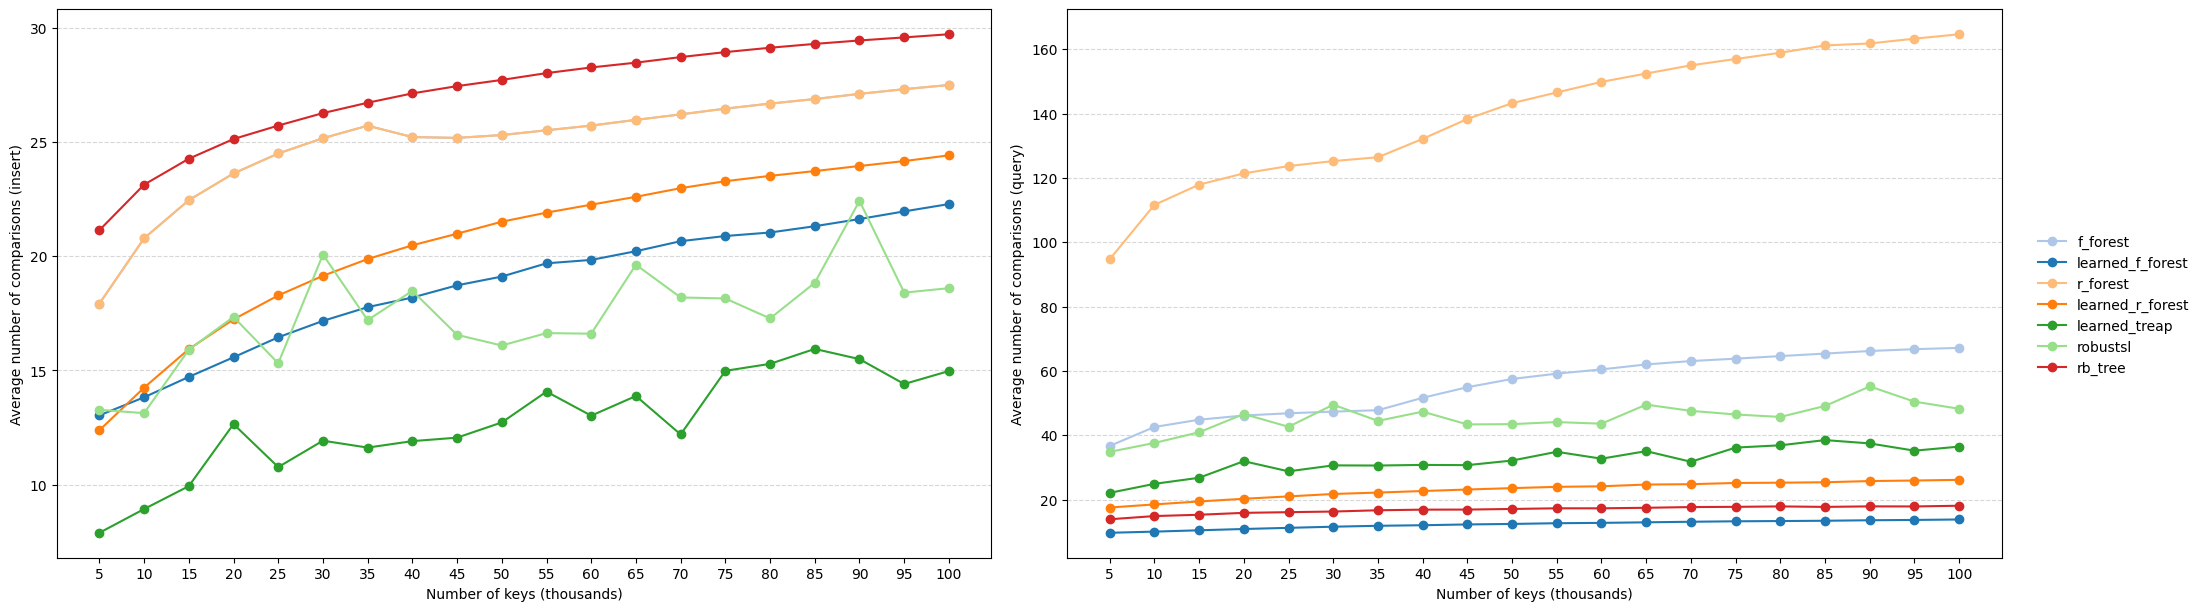

{5: {'f_forest': 36.679794, 'learned_f_forest': 9.683119, 'r_forest': 94.713994, 'learned_r_forest': 17.533972, 'learned_treap': 22.09706, 'robustsl': 34.849214, 'rb_tree': 13.884235}, 10: {'f_forest': 42.575831, 'learned_f_forest': 10.046976, 'r_forest': 111.627732, 'learned_r_forest': 18.506532, 'learned_treap': 24.897716, 'robustsl': 37.611114, 'rb_tree': 14.88286}, 15: {'f_forest': 44.842191, 'learned_f_forest': 10.461539, 'r_forest': 117.923497, 'learned_r_forest': 19.422488, 'learned_treap': 26.788263, 'robustsl': 40.932184, 'rb_tree': 15.294376}, 20: {'f_forest': 46.149233, 'learned_f_forest': 10.863396, 'r_forest': 121.420482, 'learned_r_forest': 20.263049, 'learned_treap': 31.946461, 'robustsl': 46.614178, 'rb_tree': 15.880921}, 25: {'f_forest': 46.840498, 'learned_f_forest': 11.222858, 'r_forest': 123.701251, 'learned_r_forest': 20.995402, 'learned_treap': 28.793206, 'robustsl': 42.641257, 'rb_tree': 16.094106}, 30: {'f_forest': 47.356256, 'learned_f_forest': 11.578256, 'r_fo

In [18]:
num_keys_options = [5 * i for i in range(1, 21)]
run_key_experiments(num_keys_options, NUM_QUERIES, ZIPF_ALPHA, PRED_EPSILON, PRED_DELTA, GEN)

In [19]:

def run_alpha_experiments(num_keys, num_queries, alpha_options, epsilon, delta, gen):
    query_stats = {}
        
    for alpha in alpha_options:
        queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
        frequencies = generate_noisy_frequencies(queries, num_keys, epsilon, delta, gen)
        ranks = generate_noisy_ranks(frequencies, epsilon, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, epsilon, delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[alpha] = out["queries"]["comparisons"]
        
    structures = list(query_stats[alpha_options[0]].keys())
    x_label = "Zipf parameter alpha"
    y_label = f"Average number of comparisons"

    bar_plot_res(alpha_options, structures, query_stats, None, x_label, y_label)
    print(query_stats)

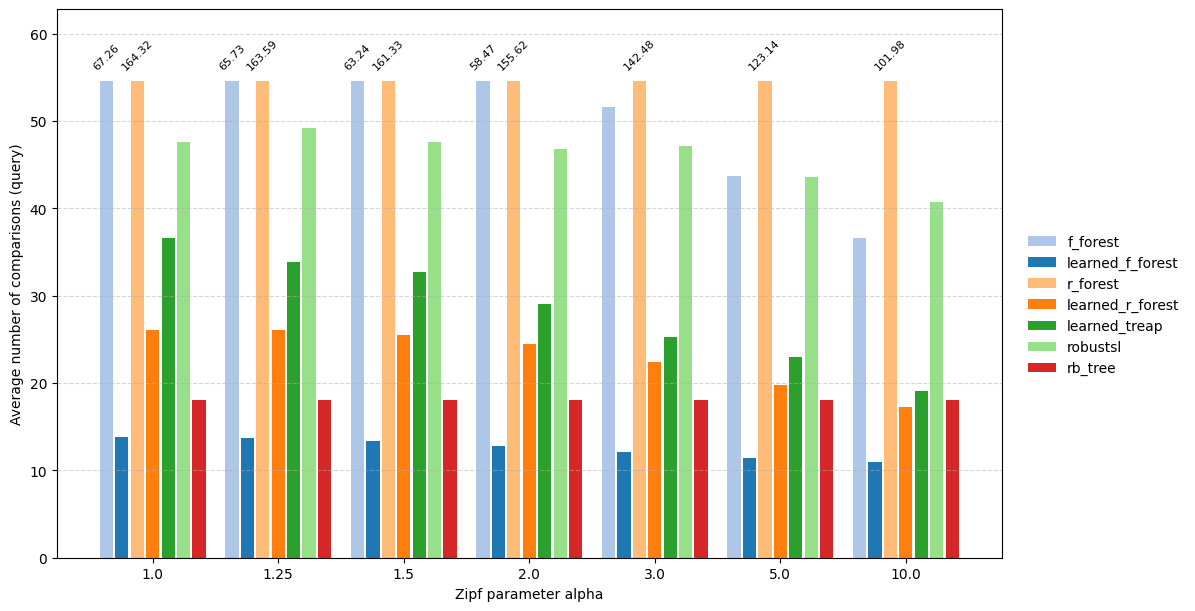

{1.0: {'f_forest': 67.256416, 'learned_f_forest': 13.825267, 'r_forest': 164.317305, 'learned_r_forest': 26.095578, 'learned_treap': 36.593537, 'robustsl': 47.548668, 'rb_tree': 18.095257}, 1.25: {'f_forest': 65.731806, 'learned_f_forest': 13.655132, 'r_forest': 163.588239, 'learned_r_forest': 26.047154, 'learned_treap': 33.898185, 'robustsl': 49.198262, 'rb_tree': 18.094705}, 1.5: {'f_forest': 63.241826, 'learned_f_forest': 13.378168, 'r_forest': 161.330511, 'learned_r_forest': 25.463638, 'learned_treap': 32.696589, 'robustsl': 47.560411, 'rb_tree': 18.101585}, 2.0: {'f_forest': 58.467809, 'learned_f_forest': 12.840078, 'r_forest': 155.616629, 'learned_r_forest': 24.473135, 'learned_treap': 29.038061, 'robustsl': 46.804091, 'rb_tree': 18.087453}, 3.0: {'f_forest': 51.555863, 'learned_f_forest': 12.114627, 'r_forest': 142.479419, 'learned_r_forest': 22.358702, 'learned_treap': 25.248011, 'robustsl': 47.122186, 'rb_tree': 18.084382}, 5.0: {'f_forest': 43.727163, 'learned_f_forest': 11.3

In [20]:
alpha_options = [1., 1.25, 1.5, 2., 3., 5., 10.]
run_alpha_experiments(NUM_KEYS, NUM_QUERIES, alpha_options, PRED_EPSILON, PRED_DELTA, GEN)

In [11]:
def run_freq_error_experiments(num_keys, num_queries, alpha, error_options, gen):
    query_stats = {}
        
    queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
    perf_epsilon, perf_delta = error_options[0]
    
    for error in error_options:
        epsilon, delta = error
        frequencies = generate_noisy_frequencies(queries, num_keys, epsilon, delta, gen)
        ranks = generate_noisy_ranks(frequencies, perf_epsilon, perf_delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, perf_epsilon, perf_delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[error] = out["queries"]["comparisons"]
        del query_stats[error]["f_forest"]
        del query_stats[error]["r_forest"]
        del query_stats[error]["learned_r_forest"]
        
    structures = list(query_stats[error_options[0]].keys())
    x_label = "Error parameters (epsilon, delta)"
    y_label = f"Average number of comparisons"
    
    bar_plot_res(error_options, structures, query_stats, None, x_label, y_label)

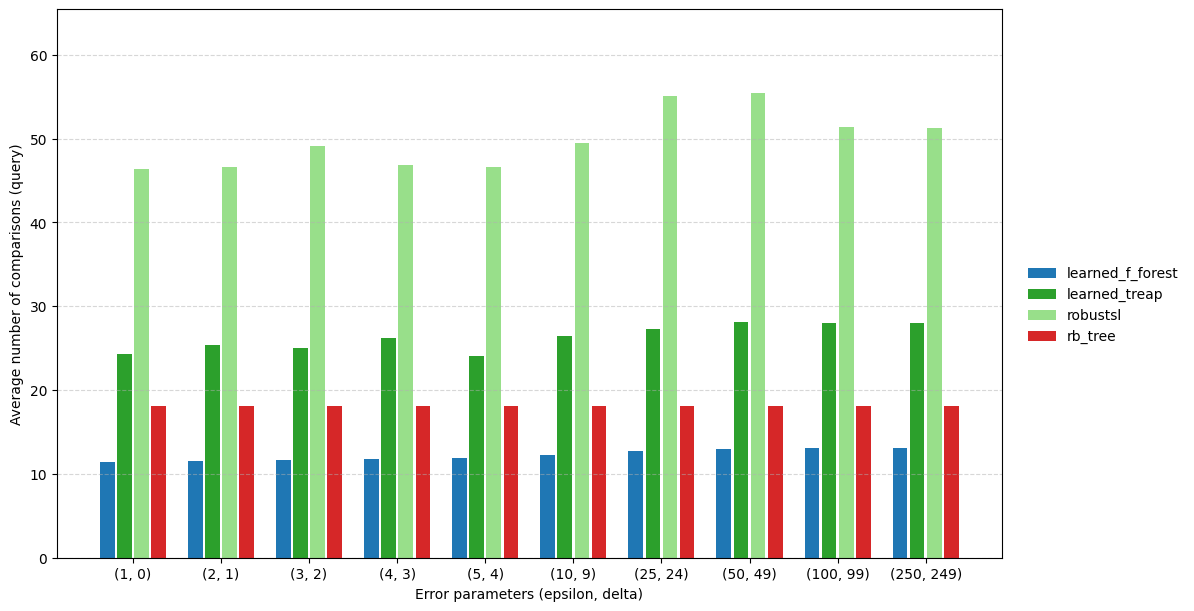

In [12]:
error_options = [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4), (10, 9), (25, 24), (50, 49), (100, 99), (250, 249)]
run_freq_error_experiments(NUM_KEYS, NUM_QUERIES, 5.0, error_options, GEN)

In [13]:
def run_rank_error_experiments(num_keys, num_queries, alpha, error_options, gen):
    query_stats = {}
        
    queries = generate_zipf_queries(num_keys, num_queries, alpha, gen)
    perf_epsilon, perf_delta = error_options[0]
    
    for error in error_options:
        epsilon, delta = error
        frequencies = generate_noisy_frequencies(queries, num_keys, perf_epsilon, perf_delta, gen)
        ranks = generate_noisy_ranks(frequencies, epsilon, delta, gen)
        accesses = generate_noisy_accesses(queries, num_keys, epsilon, delta, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen)

        query_stats[error] = out["queries"]["comparisons"]
        del query_stats[error]["f_forest"]
        del query_stats[error]["r_forest"]
        del query_stats[error]["robustsl"]
        
    structures = list(query_stats[error_options[0]].keys())
    x_label = "Error parameters (epsilon, delta)"
    y_label = f"Average number of comparisons" 
    
    bar_plot_res(error_options, structures, query_stats, None, x_label, y_label, False, 10)

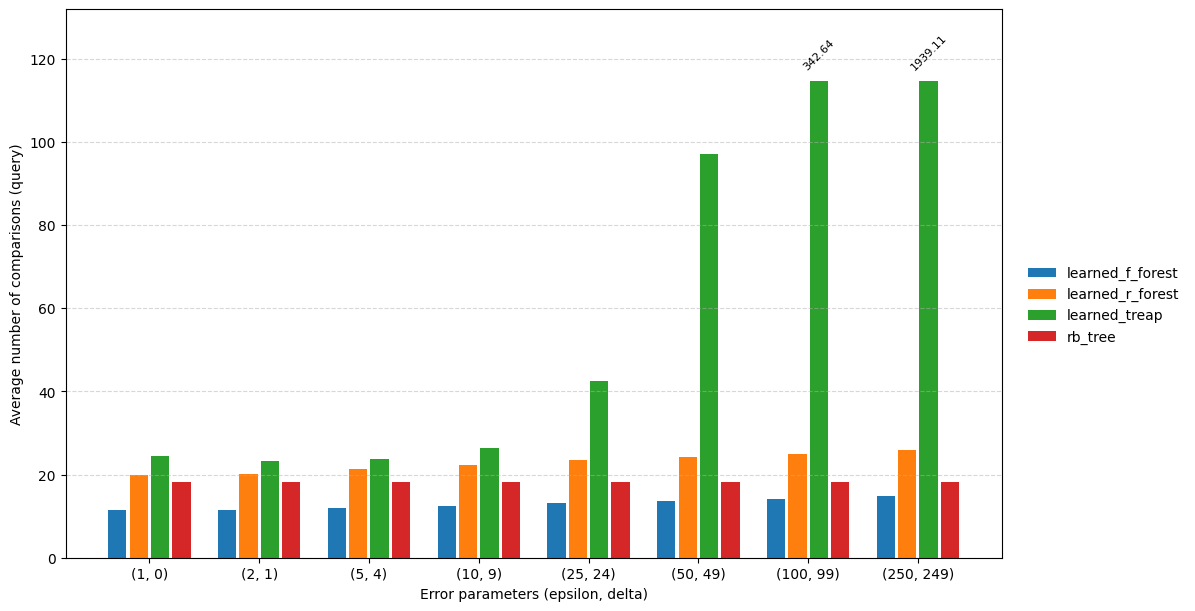

In [14]:
error_options = [(1, 0), (2, 1), (5, 4), (10, 9), (25, 24), (50, 49), (100, 99), (250, 249)]
run_rank_error_experiments(NUM_KEYS, NUM_QUERIES, 5.0, error_options, GEN)

In [21]:
def run_real_data_experiments(queries, frequencies_options, x_tick_options, gen):
    query_stats = {}
    for i in range(len(frequencies_options)):
        frequencies = frequencies_options[i]
        ranks = generate_noisy_ranks(frequencies, PRED_EPSILON, PRED_DELTA, gen)
        accesses = generate_noisy_accesses(queries, len(frequencies), PRED_EPSILON, PRED_DELTA, gen)
        out = benchmark(queries, frequencies, ranks, accesses, gen, True)

        query_stats[x_tick_options[i]] = out["queries"]["comparisons"]
        del query_stats[x_tick_options[i]]["f_forest"]
        del query_stats[x_tick_options[i]]["r_forest"]
        del query_stats[x_tick_options[i]]["learned_r_forest"]
        
    structures = list(query_stats[x_tick_options[0]].keys())
    x_label = "Frequency predictions"
    y_label = f"Average number of comparisons"
    
    bar_plot_res(x_tick_options, structures, query_stats, None, x_label, y_label, False, 4)
    print(query_stats)

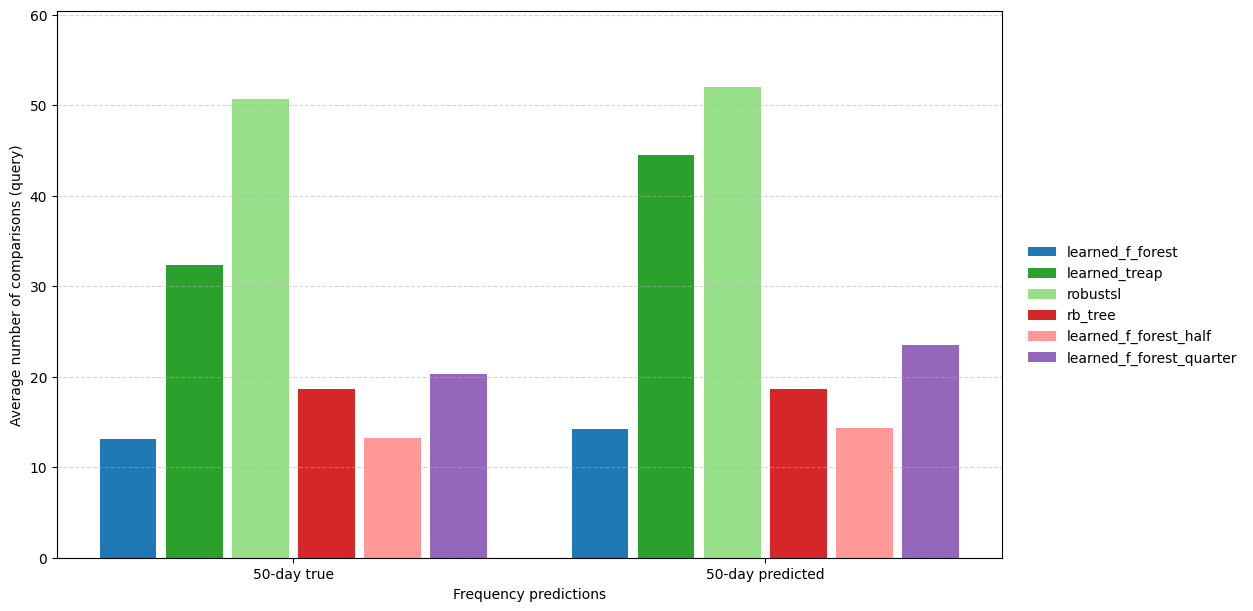

{'50-day true': {'learned_f_forest': 13.139262416739799, 'learned_treap': 32.35529609693166, 'robustsl': 50.691645063837875, 'rb_tree': 18.696283774219772, 'learned_f_forest_half': 13.239247453157923, 'learned_f_forest_quarter': 20.34669810366931}, '50-day predicted': {'learned_f_forest': 14.247161974707502, 'learned_treap': 44.4685582791072, 'robustsl': 52.068217756514215, 'rb_tree': 18.696283774219772, 'learned_f_forest_half': 14.318210679144407, 'learned_f_forest_quarter': 23.474491137110896}}


In [22]:
import numpy as np
import random

true_frequencies = np.load('data/aol_0050_len60.npz')["counts"]
pred_frequencies = np.load('data/aol_inf_all_v05_t50_exp22_aol_5d_r1-h1_u256-32_eb64_bs128_ra_20180514-160509_ep190_res.npz')["test_output"]

true_frequencies = [int(f) for f in true_frequencies]
pred_frequencies = [max(int(round(f[0])), 0) for f in pred_frequencies]

combined = list(zip(true_frequencies, pred_frequencies))
random.shuffle(combined)
true_frequencies, pred_frequencies = zip(*combined)

queries = []
for i, freq in enumerate(true_frequencies):
    queries.extend([i] * freq)
random.shuffle(queries)

frequencies_options = [true_frequencies, pred_frequencies]
x_tick_options = ["50-day true", "50-day predicted"]

run_real_data_experiments(queries, frequencies_options, x_tick_options, GEN)